In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

In [9]:
raw_data = pd.read_csv("data/raw_data.txt", skiprows=5, encoding="latin-1", delimiter = "	", header=None, na_filter=True, usecols=list(range(1,10)))

In [10]:
raw_data

,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
507,0,0,0,0,0,0,0,0,0
508,0,0,0,0,0,0,0,0,0
509,0,0,0,0,0,0,0,0,0
510,0,0,0,0,0,0,0,0,0


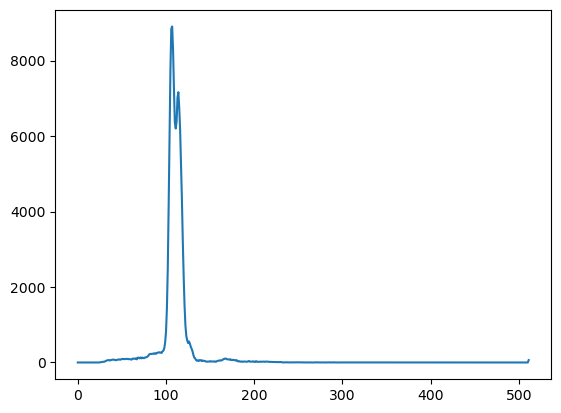

In [11]:
plt.plot(raw_data.iloc[:,7])
plt.show()

In [12]:
def callibration(n1,n2,E1,E2):
    m = (E2-E1)/(n2-n1)
    c = E2-m*n2
    return m, c

In [16]:
#function to find full width at half maximum (FWHM) of peak
def fwhm(x_values, y_values):
    # Find the maximum y-value and corresponding x-value
    max_y = max(y_values)
    max_x = x_values[y_values.index(max_y)]

    # Calculate half maximum
    half_max = max_y / 2

    # Find the indices of the points on either side of the peak where the y-value
    # crosses half maximum
    left_index = 0
    right_index = len(x_values) - 1
    for i in range(len(x_values)):
        if y_values[i] > half_max:
            left_index = i
            break
    for i in range(len(x_values) - 1, -1, -1):
        if y_values[i] > half_max:
            right_index = i
            break

    # Calculate the full width at half maximum
    fwhm = x_values[right_index] - x_values[left_index]

    return fwhm
#x_values = [1, 2, 3, 4, 5]
#y_values = [2, 4, 6, 4, 2]
#fwhm = fwhm(x_values, y_values)
#print(fwhm) # Output: 4
#plt.plot(x_values, y_values)



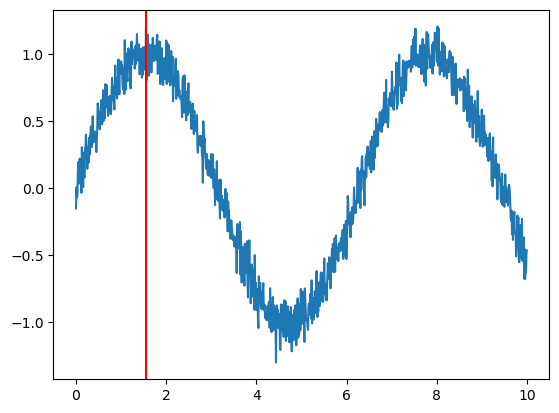

In [19]:
def find_peak(x, y, xmin, xmax):
    """
    Finds the maximum peak in a given range of x-values
    
    Arguments:
    x -- array of x-values
    y -- array of y-values
    xmin -- minimum x-value of range to search for peak
    xmax -- maximum x-value of range to search for peak
    
    Returns:
    x_peak -- x-value of peak
    y_peak -- y-value of peak
    """
    # Get indices corresponding to x-range
    ind_range = np.where(np.logical_and(x >= xmin, x <= xmax))
    
    # Get max y-value and its corresponding x-value in the range
    y_peak = np.max(y[ind_range])
    x_peak = x[ind_range][np.argmax(y[ind_range])]
    
    return x_peak, y_peak


# Generate example data
x = np.linspace(0, 10, 1000)
y = np.sin(x) + np.random.normal(0, 0.1, len(x))

# Plot data
plt.plot(x, y)

# Find peak between x=3 and x=6
xmin = 0
xmax = 4
x_peak, y_peak = find_peak(x, y, xmin, xmax)

# Plot peak as vertical line
plt.axvline(x=x_peak, color='r')

# Show plot
plt.show()



2.3858856552423573


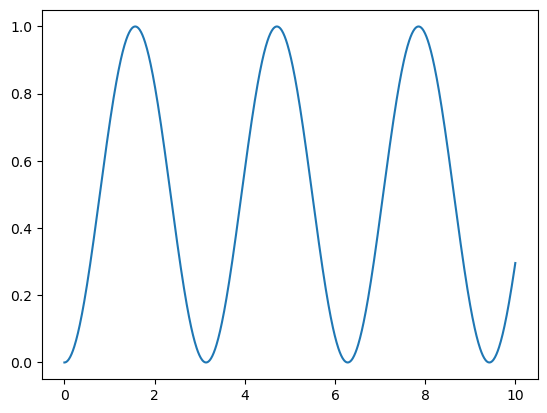

In [45]:
def count_rate(x, y, t):
    return sp.integrate.trapz(y, x)/t

count_rate = count_rate(x,y,2)
print(count_rate)
plt.plot(x,y)
plt.show()


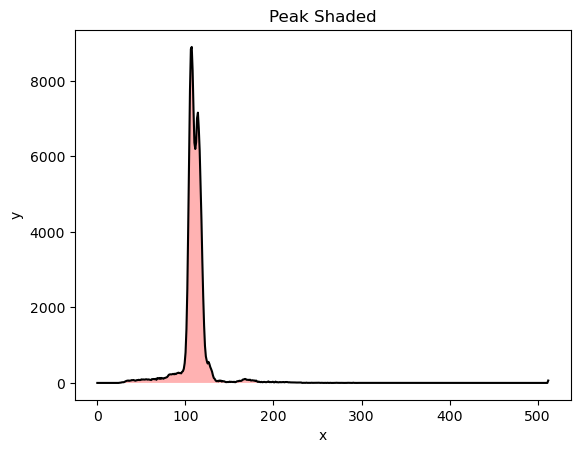

137841.72211350294


In [71]:
import matplotlib.pyplot as plt
import numpy as np

#function to find peak area
def peak_area(x_values, y_values):
    return sp.integrate.trapz(y_values, x_values)

def shade_peak(x, y, peak_xmin, peak_xmax, ax=None):
    """
    Shade the area under the curve between peak_xmin and peak_xmax.
    """
    if ax is None:
        ax = plt.gca()

    mask = (x >= peak_xmin) & (x <= peak_xmax)
    x_masked = np.ma.masked_where(~mask, x)
    y_masked = np.ma.masked_where(~mask, y)

    ax.fill_between(x_masked, 0, y_masked, alpha=0.3, edgecolor=None, facecolor='red')
    ax.plot(x, y, 'k-')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Peak Shaded')
    plt.show()
x= np.linspace(0, len(raw_data.iloc[:,7]), len(raw_data.iloc[:,7]))
shade_peak(x,raw_data.iloc[:,7], 0, 500)
peak_area = peak_area(x,raw_data.iloc[:,7])
print(peak_area)


5.596


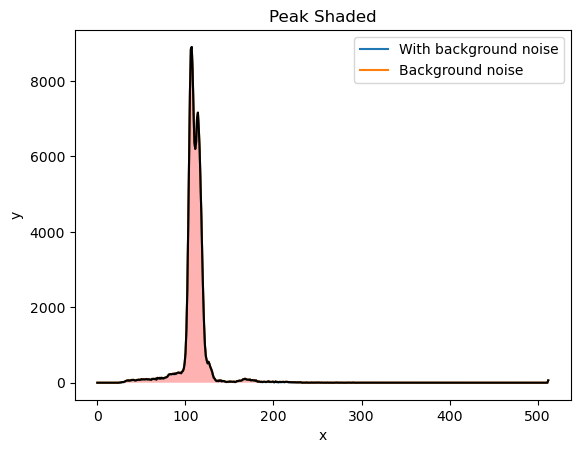

In [86]:
# Generate sample data with background noise
x= np.linspace(0, len(raw_data.iloc[:,7]), len(raw_data.iloc[:,7]))
y = raw_data.iloc[:,7]

# Calculate background noise by taking the mean of the first and last 20 points
bg_mean = np.mean(np.concatenate([y[:50], y[-200:]]))
print(bg_mean)
# Subtract background noise from y data
y -= bg_mean
#function to find peak area
def peak_area1(x_values, y_values):
    return sp.integrate.trapz(y_values, x_values)
# Plot original and adjusted data
peak_area = peak_area1(x,y)
fig, ax = plt.subplots()
ax.plot(x, y, label="With background noise")
ax.plot(x, y+bg_mean, label="Background noise")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
shade_peak(x,raw_data.iloc[:,7], 0, 500)
plt.show()


In [121]:
from scipy.optimize import curve_fit

def gaussian(x, peak_pos, std_dev, intensity):
        """
        Gaussian function.
        """
        return intensity * np.exp(-(x - peak_pos)**2 / (2 * std_dev**2))
def fit_gaussian(x, y):
    """
    Fits a Gaussian curve to x and y data and returns the three fit parameters.
    
    Parameters:
    x (array): x data.
    y (array): y data.
    
    Returns:
    tuple: A tuple containing the three fit parameters: peak position, standard deviation, and intensity.
    """
    # Initial guess for the fit parameters
    peak_pos_guess = x[np.argmax(y)]
    std_dev_guess = np.std(x)
    intensity_guess = np.max(y)
    
    # Perform the curve fit
    popt, pcov = curve_fit(gaussian, x, y, p0=[peak_pos_guess, std_dev_guess, intensity_guess])

    # Return the fit parameters
    return popt, pcov


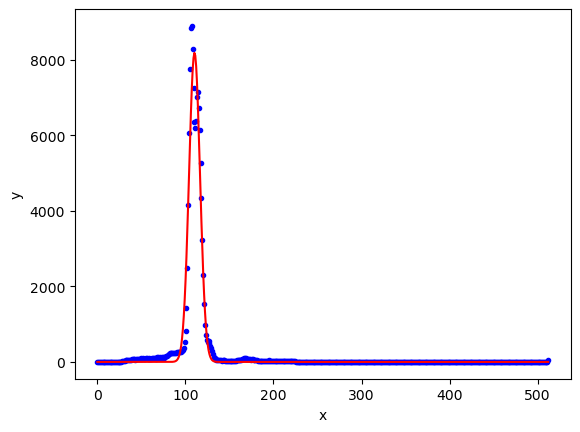

Fit parameters:
Peak position = 110.367 +/- 0.085
Standard deviation = 6.237 +/- 0.085
Intensity = 8192.286 +/- 96.318


In [124]:
# Generate some example data
x = np.linspace(0, len(raw_data.iloc[:,7]), len(raw_data.iloc[:,7]))
y = raw_data.iloc[:,7]

# Fit the data to a Gaussian curve
popt, pcov = fit_gaussian(x, y)
perr = np.sqrt(np.diag(pcov))

# Plot the data and the fit
plt.plot(x, y, 'b.')
plt.plot(x, gaussian(x, popt[0],popt[1], popt[2]), 'r-')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print("Fit parameters:")
print("Peak position = {:.3f} +/- {:.3f}".format(popt[0], perr[0]))
print("Standard deviation = {:.3f} +/- {:.3f}".format(popt[1], perr[1]))
print("Intensity = {:.3f} +/- {:.3f}".format(popt[2], perr[2]))

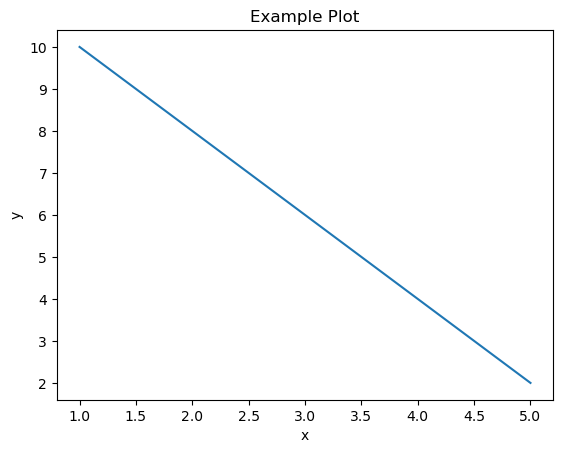

In [128]:
# Generate some example data
x = [1, 2, 3, 4, 5]
y = [10, 8, 6, 4, 2]

# Create a plot
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Example Plot')

# Save the plot to a folder named "plots"
folder_path = "figures"
file_name = "example_plot.png"
plt.savefig(f"{folder_path}/{file_name}")